# APJ Letter HST WFC3 Grism test

In [1]:
import astropy.io
from astropy.io import fits
from astropy.table import vstack, Table
import dust_extinction
from astropy.modeling.models import BlackBody
import astropy.units as u
from dust_extinction.parameter_averages import F19
#import astroquery
import numpy as np
from numpy.polynomial.polynomial import polyfit
from numpy.polynomial.polynomial import Polynomial as Poly
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import StringIO 
import csv
import scipy.stats as stats
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#import sys
#locate_python = sys.exec_prefix
#print(locate_python)

# 3D HST and WISP data
- Filtered only high S/N, > 3
- No AGN

In [36]:
# Data files

## SDSS
#SSDS galaxy data from: https://www.sdss3.org/dr8/spectro/galspec.php

# windows file path format: pd.read_csv(r"C:\Users\pheretz\Desktop\URSI_Internship\Sources Info Sheet - Catalog (8.26).csv")


## BATTISTI SDSS DATA
# source paper: https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.4431B/abstract

#import dat files:
BattistiSpecLine = np.genfromtxt('SDSS_DR7_sfg_lines.dat', names=True)
BattistiSpecProp = np.genfromtxt('SDSS_DR7_sfg_prop.dat', names=True)
#see column names:
#print(BattistiSpecProp.dtype.names)
#print(BattistiSpecProp[5])
#print(BattistiSpecLine.dtype.names)
# Stellar mass
w = np.where(BattistiSpecProp['logM_p50']>0)[0]  
#print(min(BattistiSpecProp['logM_p50'][w]))
#print(max(BattistiSpecProp['logM_p50'][w]))
print(sum(BattistiSpecProp['logM_p50'][w])/len(BattistiSpecProp['logM_p50'][w]))
SDSS_logM = BattistiSpecProp['logM_p50'][w]
# SFR
s = np.where(BattistiSpecProp['logSFR_p50']>-10)[0]  
#print(min(BattistiSpecProp['logSFR_p50'][w]))
#print(max(BattistiSpecProp['logSFR_p50'][w]))
print(sum(BattistiSpecProp['logSFR_p50'][w])/len(BattistiSpecProp['logSFR_p50'][w]))
SDSS_logSFR = BattistiSpecProp['logSFR_p50'][s]


## MAPPINGS
BPASS = np.genfromtxt('grid_bpass_P6.csv',names=True,delimiter=",", dtype=str)
#display(BPASS)
#BPASScols = BPASS.columns
#print(BPASS.dtype.names)

## BATTISTI HST DATA
# source paper: https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.4431B/abstract

#import dat files:
Battisti3DHST = np.genfromtxt('stacklist_3DHST.dat', names=True)
print(Battisti3DHST.dtype.names)
Battisti3DHST = pd.DataFrame(Battisti3DHST)
BattistiWISP= np.genfromtxt('stacklist_WISP_sample.dat', names=True)
print(BattistiWISP.dtype.names)
BattistiWISP = pd.DataFrame(BattistiWISP)

# 3D-HST
foiii3D = Battisti3DHST['foiii']
foii3D = Battisti3DHST['foii']
eoiii3D = Battisti3DHST['eoiii']
fhanii3D = Battisti3DHST['fhanii']
ehanii3D = Battisti3DHST['ehanii']
# WISP
foiiiWISP = BattistiWISP['foiii']
foiiWISP = BattistiWISP['foii']
eoiiiWISP = BattistiWISP['eoiii']
fhaniiWISP = BattistiWISP['fhanii']
ehaniiWISP = BattistiWISP['ehanii']
idwisp = BattistiWISP['ID']
fieldwisp = BattistiWISP['Field']
#print(idwisp[111])
#print(fieldwisp[111])

# filter out S/N < 3 
# check how many sources have S/N>3 in both oiii and hanii (Ha+[NII])
# could add rest of list back as non detections

SN_3DHST = Battisti3DHST.loc[((foiii3D / eoiii3D) > 3 ) & ((fhanii3D / ehanii3D) > 3)]
# There are no AGNS in this sample
SN_3DHST_AGN = SN_3DHST.loc[SN_3DHST['AGN_flag'] > 0] # len = 0
Nondet_3DHST = Battisti3DHST.loc[((foiii3D / eoiii3D) < 3 ) & ((fhanii3D / ehanii3D) < 3)]
NondetOIII_3DHST = Battisti3DHST.loc[((foiii3D / eoiii3D) < 3 )]
NondetHaNII_3DHST = Battisti3DHST.loc[((fhanii3D / ehanii3D) < 3)]
SN_3DHST.head()
print(SN_3DHST['ID'])


SN_WISP = BattistiWISP.loc[((foiiiWISP / eoiiiWISP) > 3 ) & ((fhaniiWISP / ehaniiWISP) > 3)]
# There are no AGNS in this sample
SN_WISP_AGN = SN_WISP.loc[SN_WISP['AGN_flag'] > 0] # len = 0
Nondet_WISP = BattistiWISP.loc[((foiiiWISP / eoiiiWISP) < 3 ) & ((fhaniiWISP / ehaniiWISP) < 3)]
NondetOIII_WISP= BattistiWISP.loc[((foiiiWISP / eoiiiWISP) < 3 )]
NondetHaNII_WISP= BattistiWISP.loc[((fhaniiWISP / ehaniiWISP) < 3)]
# 21 galaxies in the S/N WISP data set do not have Hb detections
SN_WISP_NO_hb = SN_WISP.loc[SN_WISP['fhb'] < 0]
# 0 galaxies in the S/N 3D HST data set do not have Hb detections
SN_3DHST_NO_hb = SN_3DHST.loc[SN_3DHST['fhb'] < 0]
#print(len(SN_WISP_AGN['AGN_flag']))

# print(len(BattistiWISP['foiii']))
# print(len(SN_WISP['foiii']))
# print(len(SN_WISP_AGN['foiii']))
# print(len(SN_3DHST_AGN['foiii']))
# print(len(Nondet_WISP['foiii']))
# print(len(NondetOIII_WISP['foiii']))
# print(len(NondetHaNII_WISP['foiii']))
#print(len(BattistiWISP['foiii']))
#print(len(SN_WISP['foiii']))
#print(len(SN_3DHST_NO_hb['foiii']))

print(max(SN_3DHST['logM']))
print(min(SN_3DHST['logM']))
print(sum(SN_3DHST['logM'])/len(SN_3DHST['logM']))
print(sum(SN_3DHST['logSFR'])/len(SN_3DHST['logSFR']))
print(sum(SN_WISP['logM'])/len(SN_WISP['logM']))
print(sum(SN_WISP['logSFR'])/len(SN_WISP['logSFR']))

SN_3DHST_logM = SN_3DHST['logM']
SN_3DHST_logSFR = SN_3DHST['logSFR']
SN_3DHST_HaN2 = SN_3DHST['fhanii']
SN_3DHST_O3 = SN_3DHST['foiii']
SN_3DHST_z = SN_3DHST['z']
SN_3DHST_ID = SN_3DHST['ID']


SN_WISP_logM = SN_WISP['logM']
SN_WISP_logSFR = SN_WISP['logSFR']
SN_WISP_HaN2 = SN_WISP['fhanii']
SN_WISP_O3 = SN_WISP['foiii']
SN_WISP_z = SN_WISP['z']
SN_WISP_ID = SN_WISP['ID']

SN_3DHST.head()


9.165737847924797
nan
('Field', 'ID', 'z', 'logM', 'logSFR', 'beta_obs', 'beta_obs_err', 'beta_SED', 'foiii', 'eoiii', 'EW_oiii_obs', 'fhb', 'ehb', 'fhanii', 'ehanii', 'EW_hanii_obs', 'fsii', 'esii', 'foii', 'eoii', 'AGN_flag', 'n_UV_filt', 'L_2800_sun_obs', 'L_2800_sun_SED')
('Field', 'ID', 'z', 'logM', 'logSFR', 'beta_obs', 'beta_obs_err', 'beta_SED', 'foiii', 'eoiii', 'EW_oiii_obs', 'fhb', 'ehb', 'fhanii', 'ehanii', 'EW_hanii_obs', 'fsii', 'esii', 'foii', 'eoii', 'fsiii_9069', 'esiii_9069', 'fsiii_9532', 'esiii_9532', 'AGN_flag', 'grism_flag')
1       1173.0
3       1560.0
6       2548.0
7       3080.0
12      3977.0
        ...   
803    39298.0
804    39374.0
805    39428.0
806    40002.0
808    41169.0
Name: ID, Length: 537, dtype: float64
10.49
7.8
9.239478584729984
0.5396461824953446
9.321659574468091
0.9116879432624105


,Field,ID,z,logM,logSFR,beta_obs,beta_obs_err,beta_SED,foiii,eoiii,...,ehanii,EW_hanii_obs,fsii,esii,foii,eoii,AGN_flag,n_UV_filt,L_2800_sun_obs,L_2800_sun_SED
1,NaN,1173.0,1.3605,9.94,1.38,-0.31,0.33,0.12,6.420000e-17,1.360000e-17,...,8.200000e-18,395.0,1.090000e-17,6.610000e-18,-1.0,-1.0,0.0,3.0,4.237760e+09,4.778130e+09
3,NaN,1560.0,1.4660,10.02,0.73,-1.96,0.27,-1.95,4.490000e-17,1.110000e-17,...,6.500000e-18,80.7,0.000000e+00,5.290000e-19,-1.0,-1.0,0.0,4.0,1.300670e+10,1.409350e+10
6,NaN,2548.0,1.4892,9.51,0.69,-1.58,0.27,-1.66,6.100000e-17,1.270000e-17,...,1.020000e-17,214.0,1.120000e-17,1.550000e-17,-1.0,-1.0,0.0,4.0,9.274880e+09,9.732060e+09
7,NaN,3080.0,1.4021,9.80,0.71,-1.46,0.27,-1.39,7.770000e-17,1.140000e-17,...,7.520000e-18,394.0,4.860000e-18,5.990000e-18,-1.0,-1.0,0.0,4.0,9.145480e+09,9.841730e+09
12,NaN,3977.0,1.4496,10.02,1.73,-1.36,0.26,-1.28,1.100000e-16,1.770000e-17,...,1.430000e-17,222.0,3.770000e-17,1.420000e-17,-1.0,-1.0,0.0,4.0,2.001220e+10,2.366710e+10


# HST vs SDSS Parameter Space

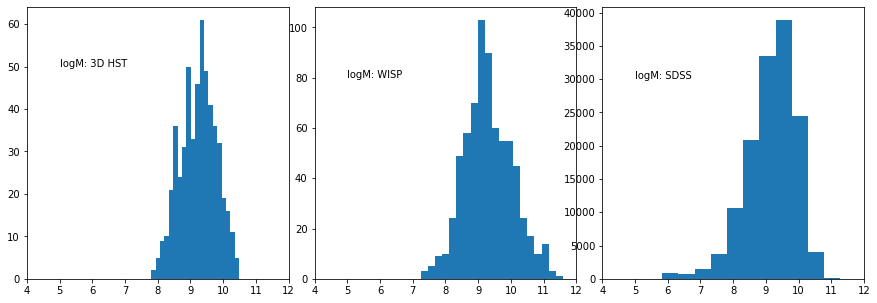

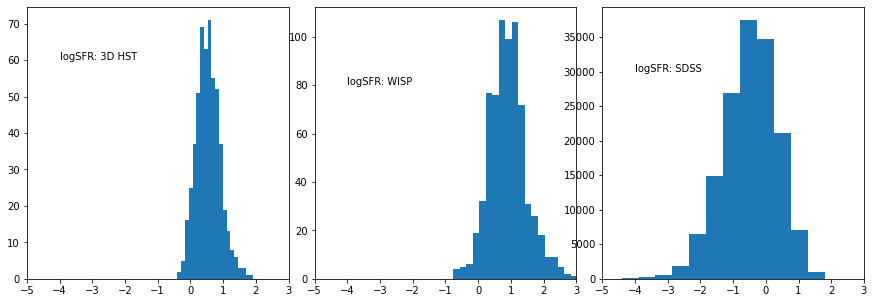

In [35]:

# plt.hist(SN_3DHST_logM, bins=20) 
# plt.text(8,50,'logM: 3D HST')
# plt.show()
# plt.hist(SN_WISP_logM, bins=20) 
# plt.text(7.5,80,'logM: WISP')
# plt.show()
# plt.hist(SDSS_logM, bins=20) 
# plt.text(3,30000,'logM: SDSS')
# plt.show()

# plt.hist(SN_3DHST_logSFR, bins=20) 
# plt.text(-0.4,60,'logSFR: 3D HST')
# plt.show()
# plt.hist(SN_WISP_logSFR, bins=20) 
# plt.text(-0.6,100,'logSFR: WISP')
# plt.show()
# plt.hist(SDSS_logSFR, bins=20) 
# plt.text(-8,35000,'logSFR: SDSS')
# plt.show()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=False,squeeze=True,figsize=(15, 5))
axs[0].hist(SN_3DHST_logM, bins=20) 
axs[0].text(5,50,'logM: 3D HST')
axs[1].hist(SN_WISP_logM, bins=20) 
axs[1].text(5,80,'logM: WISP')
axs[2].hist(SDSS_logM, bins=20)  
axs[2].text(5,30000,'logM: SDSS')
plt.xlim(4,12)
plt.subplots_adjust(wspace=0.1, hspace=0.00)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=False,squeeze=True,figsize=(15, 5))
axs[0].hist(SN_3DHST_logSFR, bins=20) 
axs[0].text(-4,60,'logSFR: 3D HST')
axs[1].hist(SN_WISP_logSFR, bins=20) 
axs[1].text(-4,80,'logSFR: WISP')
axs[2].hist(SDSS_logSFR, bins=20)   
axs[2].text(-4,30000,'logSFR: SDSS')
plt.xlim(-5,3)
plt.subplots_adjust(wspace=0.1, hspace=0.00)


# 3D HST test
- Created a bin with a similar range of logM and logSFR as SDSS:
    - SDSS avgs: logM = 9.17, logSFR = 0.46
    - Bins: 9.0 < logM < 9.5, logSFR = 0.4 < logSFR < 0.5
- 22 galaxies in bin
- Might be compelling to test with each polynomial fit? See how they compare? 

In [79]:
SN_3DHST_SDSSbin = SN_3DHST.loc[(SN_3DHST_logM > 9.0)&(SN_3DHST_logM < 9.5)&(SN_3DHST_logSFR > 0.4)&(SN_3DHST_logSFR < 0.5)] # len = 0

#print(len(SN_3DHST_SDSSbin))

print("3DHST in SDSS logM and logSFR range. LogOH from D16 poly fit to HaN2/O3")

for i in range(len(SN_3DHST_SDSSbin)):
    z = SN_3DHST_SDSSbin.iloc[i, 2]
    han2 = SN_3DHST_SDSSbin.iloc[i, 13]
    o3 = SN_3DHST_SDSSbin.iloc[i, 8]
    x = han2/o3
    logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
    print("z=",z, "logOH=",logOH)


3DHST in SDSS logM and logSFR range. LogOH from D16 poly fit to HaN2/O3
z= 1.3585 logOH= 8.139773777155435
z= 1.3384 logOH= 8.151540827593696
z= 1.3551 logOH= 8.355696011193364
z= 1.3908 logOH= 8.15855681867
z= 1.4153 logOH= 8.079912919824544
z= 1.3971 logOH= 8.33818174821231
z= 1.5005 logOH= 8.263654194164763
z= 1.4401 logOH= 8.246704921594477
z= 1.4961 logOH= 8.32754855702897
z= 1.4926 logOH= 8.391534610155592
z= 1.5113 logOH= 8.325793530498895
z= 1.4893 logOH= 8.236940097256587
z= 1.3549 logOH= 8.210833463338979
z= 1.3294 logOH= 8.241529012825179
z= 1.3657 logOH= 8.273666000207013
z= 1.3479 logOH= 8.400820541100451
z= 1.4602 logOH= 8.408733196478417
z= 1.4278 logOH= 8.27727029747166
z= 1.365 logOH= 8.065425927531091
z= 1.4605 logOH= 8.353568624573697
z= 1.4733 logOH= 8.173957725035274
z= 1.4157 logOH= 8.357435927355615


In [64]:
# Create 3D HST logM and logSFR bin


# w = np.where((SN_3DHST_logM > 9.0)&(SN_3DHST_logM < 9.5)&(SN_3DHST_logSFR > 0.4)&(SN_3DHST_logSFR < 0.5))[0] 
# print(len(w))
# print(w)

# b = np.where((SN_3DHST_logM > 9.0)&(SN_3DHST_logM < 9.5)&(SN_3DHST_logSFR > 0.5)&(SN_3DHST_logSFR < 0.6))[0] 
# print(len(b))
# print(b)

Id = SN_3DHST_ID[25]
print(Id)

han2 = SN_3DHST_HaN2[26]
o3 = SN_3DHST_O3[26]
z = SN_3DHST_z[26]
Id = SN_3DHST_ID[26]
print(z)
print(Id)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_3DHST_HaN2[51]
o3 = SN_3DHST_O3[51]
z = SN_3DHST_z[51]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_3DHST_HaN2[138]
o3 = SN_3DHST_O3[138]
z = SN_3DHST_z[138]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_3DHST_HaN2[160]
o3 = SN_3DHST_O3[160]
z = SN_3DHST_z[160]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_3DHST_HaN2[174]
o3 = SN_3DHST_O3[174]
z = SN_3DHST_z[174]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

SN_3DHST_SDSSbin.head()

KeyError: 25

In [61]:
# Create WISP logM and logSFR bin

w = np.where((SN_WISP_logM > 9.0)&(SN_WISP_logM < 9.5)&(SN_WISP_logSFR > 0.4)&(SN_WISP_logSFR < 0.5))[0] 
print(len(w))
print(w)

han2 = SN_WISP_HaN2[13]
o3 = SN_WISP_O3[13]
z = SN_WISP_z[13]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_WISP_HaN2[216]
o3 = SN_WISP_O3[216]
z = SN_WISP_z[216]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)

han2 = SN_WISP_HaN2[408]
o3 = SN_WISP_O3[408]
z = SN_WISP_z[408]
print(z)

x = han2/o3
# D16/H23 fit
logOH = 0.06079696*x**3 -0.44224322*x**2 +  1.32832187*x +  7.55164327
print(logOH)



7
[ 13 216 243 264 408 641 701]
1.3596
8.453810676476161
0.6592
7.918315421805023
1.0823
8.928072260290568


In [ ]:
# 